In [1]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '.'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

We will solve problem from https://arxiv.org/pdf/2111.02801:

Given domain $[0, T] \times [A, B]$, and functions $f(x)$, $g_1(t)$ и $g_2(t)$, find such $u(t, x)$ so that

$$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} + 5(u - u^3)$$
$$u(0, x) = f(x), \quad u(t, A) = g_1(t), \quad u(t, B) = g_2(t)$$

As in paper, we fix domain as $[0, 1] \times [-1, 1]$, diffusion coefficient $D = 0.001$ and

$$f(x) = x^2 \cos(\pi x) \quad g_1(t) = g_2(t) = -1$$

As in diffusion problem, we assume that boundary values are given as finite collection of measurements and stored on disk.

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from pinns.samplers import RandomSampler, ConstantSampler, DataSampler

path = './data/allen-cahn/'


''' -- CONSTRAINTS -- '''


def get_data(path):
    init = torch.tensor(np.load(path + 'init_data.npy'))
    left = torch.tensor(np.load(path + 'left_data.npy'))
    right = torch.tensor(np.load(path + 'right_data.npy'))
    
    return ([init[:,  :2], left[:,  :2], right[:,  :2]], 
            [init[:, [2]], left[:, [2]], right[:, [2]]])

pts, data = get_data(path)
constraints_sampler = ConstantSampler((pts, data))


''' -- COLLOCATION -- '''


domain = {'t': [0, 1], 'x': [-1, 1]}
collocation_sampler = RandomSampler(domain, 2048)


''' -- VALIDATION DATA -- '''


test_data_sampler = DataSampler(path + 'solution.npy', 512, 2)

In [4]:
from pinns.derivatives import Derivative

d = Derivative(method='autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    D = 0.001
    ):
    
    # We do not need left and right because we are solving 
    # Dirichlet problem and we just compare predictions and 
    # solution. If we solve Cauchy or Robin problem, we 
    # need to calculate derivatives at boundary points.
    
    init_pts, left_pts, right_pts = cstr_pts
    init_pred, left_pred, right_pred = cstr_pred
    init_vals, left_vals, right_vals = cstr_vals
    
    t, x = coll_pts['t'], coll_pts['x']
    
    def initial_loss():
        return torch.mean(torch.square(init_pred - init_vals))
    
    def left_loss():
        return torch.mean(torch.square(left_pred - left_vals))
    
    def right_loss():
        return torch.mean(torch.square(right_pred - right_vals))
    
    def pde_loss(u, t, x):
        ut  = d(u,  t)
        uxx = d(u,  x, orders = 2)
        return torch.mean(torch.square(ut - D * uxx - 5 * (u - u**3)))
    
    return (
        initial_loss(), 
        left_loss(), 
        right_loss(), 
        pde_loss(coll_pred, t, x)
    )

In [17]:
from pinns import Trainer
from pinns.models import FF
from pinns.activations import Swish
from pinns.optimizers import Adam
from pinns.errors import l2 as metric

pinn = FF([2] + [8, 8] + [1], activ=nn.Tanh())

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs = [0.75]*3 + [0.25],
    test_points_sampler = test_data_sampler
)

num_iters = 5000
save_every = 25

def make_plot():
    if trainer.iter == 0 or trainer.iter % save_every == 0 or trainer.iter == num_iters:
        preds = pinn.predict(test_data_sampler(full=True)[0]).detach()
        np.save(f'./.temp/{trainer.iter}.npy', preds.numpy())

trainer.train(
    num_iters=num_iters,
    optimizers=[(0, adam)],
    validate_every=1,
    error_metric=metric,
    at_training_start_callbacks=[make_plot],
    at_epoch_end_callbacks=[make_plot],
    at_training_end_callbacks=[make_plot]
    )

  0%|          | 0/5000 [00:00<?, ?it/s]

In [18]:
trainer.evaluate(metric, full = True)

81.13708

In [19]:
# We know the shape of test data.
Nt, Nx = 101, 201
pts, values = test_data_sampler(full=True)

pts = [
    pts[:,0].reshape(Nt, Nx),
    pts[:,1].reshape(Nt, Nx)
]
values = values.reshape(Nt, Nx)

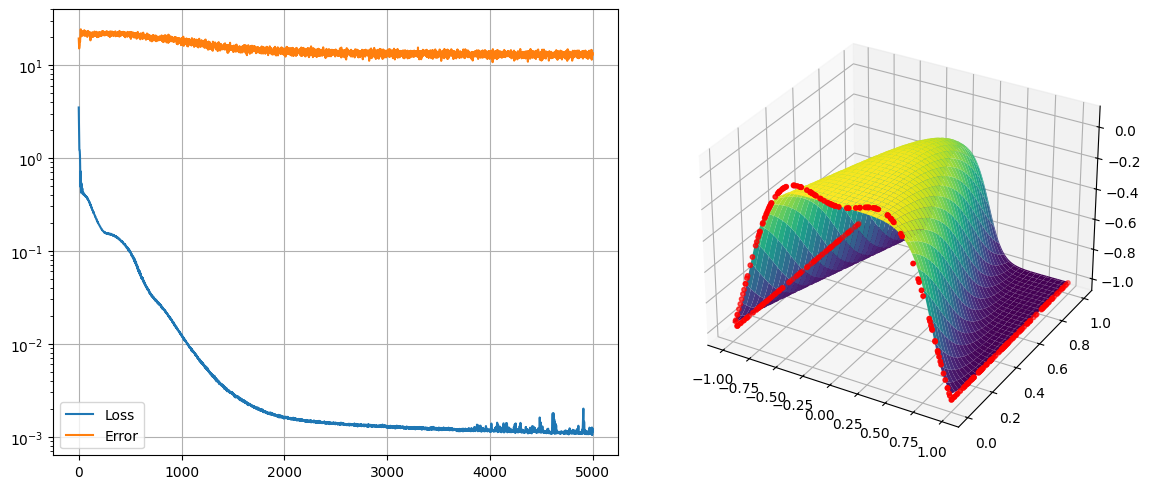

In [20]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121)
ax.plot(trainer.loss_history, label='Loss')
ax.plot(range(0, trainer.iter + 1, 1), trainer.error_history, label='Error')
ax.grid()
ax.set_yscale('log')
ax.legend()

preds = pinn.predict(test_data_sampler(full=True)[0]).detach().reshape(Nt, Nx)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(pts[1], pts[0], preds, cmap='viridis')
# ax.plot_surface(pts[1], pts[0], values, cmap='viridis')

cstr_pts, cstr_vals = constraints_sampler()
stacked_pts = torch.cat([torch.hstack([t[:, [1]], t[:, [0]]]) for t in cstr_pts])
stacked_vals = torch.cat(cstr_vals)
constraints = torch.hstack([stacked_pts, stacked_vals.reshape(-1, 1)]).T

ax.scatter3D(*constraints, color='r', s=10)
# ax.view_init(80, -120)

plt.tight_layout()
plt.show()

In [21]:
from PIL import Image
import imageio
from joblib import Parallel, delayed

from tqdm.notebook import tqdm_notebook as tqdm

def save_animation(files, path, duration=5, fps=60, loop=0, type='mp4', processors=2, ):
    
    fig = plt.figure(figsize=(6, 6))
    
    def plot(i):
        predictions = np.load(files[i]).reshape(Nt, Nx)
        ax = fig.add_subplot(111, projection='3d')
        # Set plot limits and labels
        ax.set_xlim(-1, 1)
        ax.set_ylim(0, 1)
        surface = ax.plot_surface(pts[1], pts[0], predictions, cmap='viridis')
        scatter = ax.scatter3D(*constraints, color='r', s=10)
        fig.savefig(f'./.temp/frame_{i}.png', dpi=300)
        fig.clear()
        
    # Number of frames
    num_frames = len(files)

    # Parallelize the plotting function
    Parallel(n_jobs=processors, verbose=10)(delayed(plot)(i) for i in range(num_frames))
    
    if type == 'mp4':
        writer = imageio.get_writer(path, fps=fps)
        for i in range(len(files)):
            writer.append_data(imageio.imread(f'./.temp/frame_{i}.png'))
        writer.close()
        
    if type == 'gif':
        imgs = [Image.open(f'./.temp/frame_{i}.png') for i in range(len(files))]
        imgs[0].save(path, save_all=True, append_images=imgs[1:], duration=duration, fps=fps, loop=loop)
    
files = [f'./.temp/{i}.npy' for i in range(0, trainer.iter, save_every)]
save_animation(files, './.results/allen cahn animation.gif', type='gif', processors=8)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   11.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   12.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   14.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   17.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   18.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   20.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   22.5s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   24.4s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   25.9s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:   28.6s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   30.6s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:   33.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   42.8s
[Parallel(

<Figure size 600x600 with 0 Axes>